# Finding an optimal microscope lens for an mhealth autonomous malaria detector

## Author: Julio Portella

The dataset to use in this project comes from tensorflow's Malaria dataset, given its quality, it can be considered as a ground truth.
For future works the dataset will incorporate other illnesses such as tuberculosis, plasmodium, etc.

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import itertools

"""
(train_examples, validation_examples), info = tfds.load(
    'malaria', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)
"""
(train_examples, validation_examples, test_examples), info = tfds.load(
    'malaria', 
    with_info=True, 
    as_supervised=True,
    shuffle_files=True,
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
)

base_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(224,224, 3))
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2))
base_model.trainable = False
model.compile(
    metrics=['accuracy'],
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
IMAGE_RES = 224

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteR59PYI/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
29089792/29084464 [==============================] - 0s 0us/step


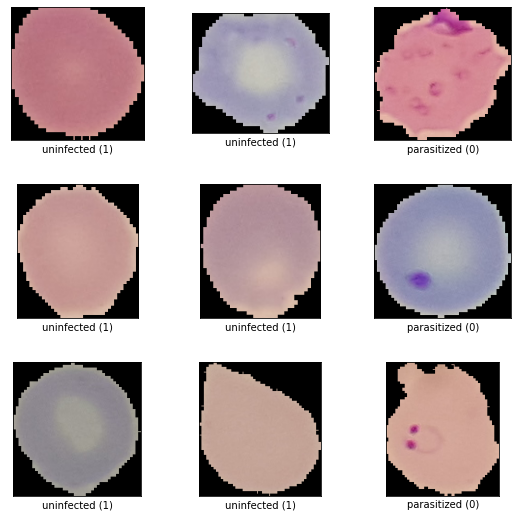

In [3]:
vis = tfds.visualization.show_examples(train_examples, info)

Defining useful functions

In [4]:
def plot_img(np_array, title="", col_bar=True):
  plt.figure()
  plt.title(title)
  plt.imshow(np_array)
  if col_bar is True:
    plt.colorbar()


In [5]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [6]:
def plot_physical_layer(selected_batch, illumination_pattern, aperture_pattern):
  plot_img(selected_batch[0,:,:,:].numpy())
  fourier_mask1 = tf.Variable(initial_value=create_circular_mask(224, 224, radius=112).astype(int), dtype='float32' ,trainable=False)
  illum =  illumination_pattern
  aperture =  aperture_pattern
  cmp_img = tf.cast(selected_batch, dtype="complex64")
  cmp_img = cmp_img * tf.exp(1j*cmp_img*optical_thickness/wavelength)
  fourier_img = tf.signal.fft2d(cmp_img)
  fourier_img =  tf.signal.fftshift(fourier_img)
  plot_img(np.log(np.abs(fourier_img[0,:,:,0].numpy())),"Red channel FFT")
  plot_img(np.log(np.abs(fourier_img[0,:,:,1].numpy())),"Green channel FFT")
  plot_img(np.log(np.abs(fourier_img[0,:,:,2].numpy())),"Blue channel FFT")
  fourier_img = tf.transpose(fourier_img, conjugate=True, perm=[0, 3, 1, 2])
    # Operations
  f_mask = tf.cast(fourier_mask1, dtype='complex64')
  fourier_img = tf.multiply(fourier_img, illum)
  fourier_img = tf.multiply(fourier_img, f_mask)
  fourier_img = tf.multiply(fourier_img, aperture)
  plot_img(np.log(np.abs(fourier_img[0,0,:,:].numpy())),"Red channel FFT")
  plot_img(np.log(np.abs(fourier_img[0,1,:,:].numpy())),"Green channel FFT")
  plot_img(np.log(np.abs(fourier_img[0,2,:,:].numpy())),"Blue channel FFT")
    #End of the operations
  fourier_img = tf.transpose(fourier_img, perm=[0,2,3,1], conjugate=True)
  fourier_img=tf.signal.ifftshift(fourier_img)
  outputs =  tf.cast(tf.signal.ifft2d(fourier_img), dtype="complex64")
  outputs = tf.cast(outputs, dtype="float32")
  gaussian_noise = tf.random.normal([224,224,3], mean=0.0, stddev=.1, dtype=tf.dtypes.float32, seed=None, name=None)
  outputs += gaussian_noise
  plot_img(outputs[0,:,:,:].numpy())
  pass

In [99]:
def plot_physical_layer_28LED(selected_batch, illumination_pattern,illumination_pattern_i, aperture_pattern):
  plot_img(selected_batch[0,:,:,:].numpy())
  fourier_mask1 = tf.Variable(initial_value=create_circular_mask(224, 224, radius=112).astype(int), dtype='float32' ,trainable=False)
  ##########
  illum =  illumination_pattern
  illum = tf.transpose(illum, conjugate=True,perm=[0,2,3,1])
  illum = tf.keras.layers.UpSampling2D(size=(8,8))(illum)
  illum = tf.transpose(illum, conjugate=True,perm=[0,3,1,2])
  illum = tf.reshape(illum,[3,224,224])
  illum_i =  illumination_pattern_i
  illum_i = tf.transpose(illum_i, conjugate=True,perm=[0,2,3,1])
  illum_i = tf.keras.layers.UpSampling2D(size=(8,8))(illum_i)
  illum_i = tf.transpose(illum_i, conjugate=True,perm=[0,3,1,2])
  illum_i = tf.reshape(illum_i,[3,224,224])
  illum =   tf.complex(illum, illum)
  ##########
  aperture =  aperture_pattern
  cmp_img = tf.cast(selected_batch, dtype="complex64")
  cmp_img = cmp_img * tf.exp(1j*cmp_img*optical_thickness/wavelength)
  fourier_img = tf.signal.fft2d(cmp_img)
  fourier_img =  tf.signal.fftshift(fourier_img)
  plot_img(np.log(np.abs(fourier_img[0,:,:,0].numpy())),"Red channel FFT")
  plot_img(np.log(np.abs(fourier_img[0,:,:,1].numpy())),"Green channel FFT")
  plot_img(np.log(np.abs(fourier_img[0,:,:,2].numpy())),"Blue channel FFT")
  fourier_img = tf.transpose(fourier_img, conjugate=True, perm=[0, 3, 1, 2])
    # Operations
  f_mask = tf.cast(fourier_mask1, dtype='complex64')
  fourier_img = tf.multiply(fourier_img, illum)
  fourier_img = tf.multiply(fourier_img, f_mask)
  fourier_img = tf.multiply(fourier_img, aperture)
  plot_img(np.log(np.abs(fourier_img[0,0,:,:].numpy())),"Red channel FFT")
  plot_img(np.log(np.abs(fourier_img[0,1,:,:].numpy())),"Green channel FFT")
  plot_img(np.log(np.abs(fourier_img[0,2,:,:].numpy())),"Blue channel FFT")
    #End of the operations
  fourier_img = tf.transpose(fourier_img, perm=[0,2,3,1], conjugate=True)
  fourier_img=tf.signal.ifftshift(fourier_img)
  outputs =  tf.cast(tf.signal.ifft2d(fourier_img), dtype="complex64")
  outputs = tf.cast(outputs, dtype="float32")
  gaussian_noise = tf.random.normal([224,224,3], mean=0.0, stddev=.1, dtype=tf.dtypes.float32, seed=None, name=None)
  outputs += gaussian_noise
  plot_img(outputs[0,:,:,:].numpy())
  pass

Testing the physical layer approach before coding. Later I figured out that the fftshift is only useful when you code outside the model, inside the model, there is no need to use the fftshift

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


1.0

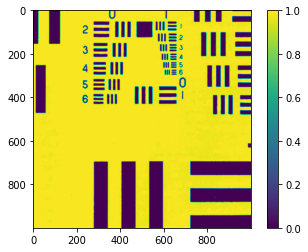

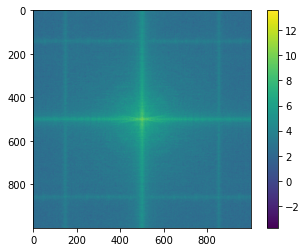

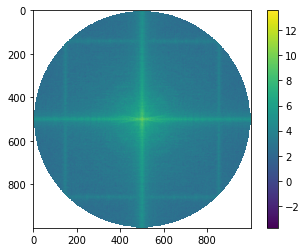

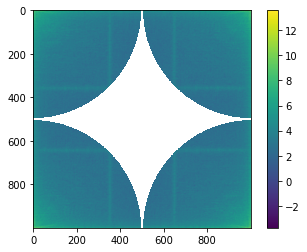

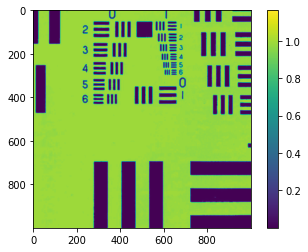

In [8]:
sample = plt.imread('resolution_target.png')
sample = sample/sample.max()
plot_img(sample)
tf_sample = tf.Variable(sample)
tf_sample = tf.cast(tf_sample, dtype="complex64")
fourier_img = tf.signal.fft2d(tf_sample)
fourier_img =  tf.signal.fftshift(fourier_img)
plot_img(np.log(np.abs(fourier_img)))
#fourier_img = tf.transpose(fourier_img, conjugate=True, perm=[2, 0, 1])
fourier_mask1 = tf.Variable(initial_value=create_circular_mask(1000,1000, radius=500).astype(int), dtype='float32' ,trainable=False)
fourier_img = tf.multiply(tf.cast(fourier_mask1, dtype="complex64"),fourier_img)
plot_img(np.log(np.abs(fourier_img[:,:].numpy())))
plot_img(np.log(np.abs(tf.signal.ifftshift(fourier_img[:,:]).numpy() )))
  #final_img = tf.signal.ifft2d(fourier_img)
fourier_img=tf.signal.ifftshift(fourier_img[:,:])
outputs =  tf.cast(tf.signal.ifft2d(fourier_img), dtype="complex64")
plot_img(np.abs(outputs.numpy()))

sample.max()

Creating the physical parameters

In [9]:
wavelength = .5
delta_x = wavelength/2
optical_thickness = 20 * wavelength

Creating the physical layers

In [87]:
class FullPhysicalLayer28Led(tf.keras.layers.Layer):
  def __init__(self, train_illumination=True, train_aperture=True):
    super().__init__()
    self.train_illumination = train_illumination
    self.train_aperture = train_aperture
  
  def build(self, input_shape):
    # expect the input_shape to be (batch_size, height, width, filters_previous)
    kernel_init = create_circular_mask(224, 224, radius=112).astype(int)
    self.fourier_mask = tf.Variable(initial_value=kernel_init, dtype='float32' ,trainable=False)
    # self.input_illumination_phase = tf.Variable(initial_value=tf.ones([64, 64], dtype="complex64"), trainable=self.train_illumination)
    
    self.input_illumination_phase = tf.Variable(initial_value=tf.ones([1,3,28, 28], dtype="float32"), constraint=lambda t: tf.clip_by_value(t, 0, 2*np.pi), trainable=True)
    self.i_input_illumination_phase = tf.Variable(initial_value=tf.zeros([1,3,28, 28], dtype="float32"), constraint=lambda t: tf.clip_by_value(t, 0, 2*np.pi), trainable=True)
    
    self.aperture_phase = tf.Variable(initial_value=tf.ones([3,224, 224], dtype="float32"), trainable=self.train_aperture)
    self.i_aperture_phase = tf.Variable(initial_value=tf.ones([3,224, 224], dtype="float32"), trainable=self.train_aperture)
    pass

  def get_config(self):
    config = super(FullPhysicalLayer, self).get_config()
    config.update({'fourier_mask': self.fourier_mask,
              'input_illumination_phase': self.input_illumination_phase,
              'i_input_illumination_phase': self.i_input_illumination_phase,
              'aperture_phase': self.aperture_phase,
              'i_aperture_phase': self.i_aperture_phase})
    return config

  def get_mask(self):
    return self.fourier_mask1

  def get_illumination_phase(self):
    illum =   tf.complex(self.input_illumination_phase, self.i_input_illumination_phase)
    return illum

  def get_aperture_phase(self):
    aperture =   tf.complex(self.aperture_phase, self.i_aperture_phase)
    return aperture

  def call(self, input):
    # Transforming everything into a phase object
    illum_ph = tf.transpose(self.input_illumination_phase, conjugate=True,perm=[0,2,3,1])
    illum_ph = tf.keras.layers.UpSampling2D(size=(8,8))(illum_ph)
    illum_ph = tf.transpose(illum_ph, conjugate=True,perm=[0,3,1,2])
    illum_i = tf.transpose(self.i_input_illumination_phase, conjugate=True,perm=[0,2,3,1])
    illum_i = tf.keras.layers.UpSampling2D(size=(8,8))(illum_i)
    illum_i = tf.transpose(illum_i, conjugate=True,perm=[0,3,1,2])
    illum =   tf.complex(illum_ph, illum_i)
    illum = tf.reshape(illum,[3,224,224])
    aperture =   tf.complex(self.aperture_phase, self.i_aperture_phase)
    gaussian_noise = tf.random.normal([224,224,3], mean=0.0, stddev=.1, dtype=tf.dtypes.float32, seed=None, name=None)
    cmp_img = tf.cast(input, dtype="complex64")
    cmp_img = cmp_img * tf.exp(1j*cmp_img*optical_thickness/wavelength)
    fourier_img = tf.signal.fft2d(cmp_img)
    #fourier_img =  tf.signal.fftshift(fourier_img)
    fourier_img = tf.transpose(fourier_img, conjugate=True, perm=[0, 3, 1, 2])
    # Operations go here
    f_mask = tf.cast(self.fourier_mask, dtype='complex64')
    fourier_img = tf.multiply(fourier_img, illum)
    fourier_img = tf.multiply(fourier_img, f_mask)
    fourier_img = tf.multiply(fourier_img, aperture)
    #End of the operations
    fourier_img = tf.transpose(fourier_img, perm=[0,2,3,1], conjugate=True)
    #fourier_img=tf.signal.ifftshift(fourier_img)
    outputs =  tf.cast(tf.signal.ifft2d(fourier_img), dtype="complex64")
    outputs = tf.cast(outputs, dtype="float32")
    outputs += gaussian_noise
    # Adding noise
    return outputs
    pass

OLD PHYSICAL LAYER

In [10]:
class FullPhysicalLayer(tf.keras.layers.Layer):
  def __init__(self, train_illumination=True, train_aperture=True):
    super().__init__()
    self.train_illumination = train_illumination
    self.train_aperture = train_aperture
  
  def build(self, input_shape):
    # expect the input_shape to be (batch_size, height, width, filters_previous)
    kernel_init = create_circular_mask(224, 224, radius=112).astype(int)
    self.fourier_mask = tf.Variable(initial_value=kernel_init, dtype='float32' ,trainable=False)
    # self.input_illumination_phase = tf.Variable(initial_value=tf.ones([64, 64], dtype="complex64"), trainable=self.train_illumination)
    
    self.input_illumination_phase = tf.Variable(initial_value=tf.ones([3,224, 224], dtype="float32"), constraint=lambda t: tf.clip_by_value(t, 0, 2*np.pi), trainable=True)
    self.i_input_illumination_phase = tf.Variable(initial_value=tf.zeros([3,224, 224], dtype="float32"), constraint=lambda t: tf.clip_by_value(t, 0, 2*np.pi), trainable=True)
    
    self.aperture_phase = tf.Variable(initial_value=tf.ones([3,224, 224], dtype="float32"), trainable=self.train_aperture)
    self.i_aperture_phase = tf.Variable(initial_value=tf.ones([3,224, 224], dtype="float32"), trainable=self.train_aperture)
    pass

  def get_config(self):
    config = super(FullPhysicalLayer, self).get_config()
    config.update({'fourier_mask': self.fourier_mask,
              'input_illumination_phase': self.input_illumination_phase,
              'i_input_illumination_phase': self.i_input_illumination_phase,
              'aperture_phase': self.aperture_phase,
              'i_aperture_phase': self.i_aperture_phase})
    return config

  def get_mask(self):
    return self.fourier_mask1

  def get_illumination_phase(self):
    illum =   tf.complex(self.input_illumination_phase, self.i_input_illumination_phase)
    return illum

  def get_aperture_phase(self):
    aperture =   tf.complex(self.aperture_phase, self.i_aperture_phase)
    return aperture

  def call(self, input):
    # Transforming everything into a phase object
    illum =   tf.complex(self.input_illumination_phase, self.i_input_illumination_phase)
    aperture =   tf.complex(self.aperture_phase, self.i_aperture_phase)
    gaussian_noise = tf.random.normal([224,224,3], mean=0.0, stddev=.1, dtype=tf.dtypes.float32, seed=None, name=None)
    cmp_img = tf.cast(input, dtype="complex64")
    cmp_img = cmp_img * tf.exp(1j*cmp_img*optical_thickness/wavelength)
    fourier_img = tf.signal.fft2d(cmp_img)
    #fourier_img =  tf.signal.fftshift(fourier_img)
    fourier_img = tf.transpose(fourier_img, conjugate=True, perm=[0, 3, 1, 2])
    # Operations go here
    f_mask = tf.cast(self.fourier_mask, dtype='complex64')
    fourier_img = tf.multiply(fourier_img, illum)
    fourier_img = tf.multiply(fourier_img, f_mask)
    fourier_img = tf.multiply(fourier_img, aperture)
    #End of the operations
    fourier_img = tf.transpose(fourier_img, perm=[0,2,3,1], conjugate=True)
    #fourier_img=tf.signal.ifftshift(fourier_img)
    outputs =  tf.cast(tf.signal.ifft2d(fourier_img), dtype="complex64")
    outputs = tf.cast(outputs, dtype="float32")
    outputs += gaussian_noise
    # Adding noise
    return outputs
    pass

Creating the model with the physical layer, in this case, we're going to use MobileNetV2 because this is the CNN that is going to be deployed inside a smartphone without internet connection

In [88]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224, 3))
model = tf.keras.Sequential()
model.add(FullPhysicalLayer28Led())
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2, activation="sigmoid"))
base_model.trainable = True
model.compile(
    metrics=['accuracy'],
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
IMAGE_RES = 224

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [89]:
# because training is slow...
EPOCHS = 35
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/35
603/603 [==============================] - 102s 170ms/step - loss: 0.4879 - accuracy: 0.8200 - val_loss: 0.8168 - val_accuracy: 0.4965
Epoch 2/35
603/603 [==============================] - 101s 167ms/step - loss: 0.4568 - accuracy: 0.8544 - val_loss: 0.8098 - val_accuracy: 0.5035
Epoch 3/35
603/603 [==============================] - 101s 168ms/step - loss: 0.4530 - accuracy: 0.8587 - val_loss: 0.7446 - val_accuracy: 0.4965
Epoch 4/35
603/603 [==============================] - 101s 167ms/step - loss: 0.4392 - accuracy: 0.8742 - val_loss: 0.9381 - val_accuracy: 0.3699
Epoch 5/35
603/603 [==============================] - 101s 167ms/step - loss: 0.4402 - accuracy: 0.8724 - val_loss: 0.6047 - val_accuracy: 0.7077
Epoch 6/35
603/603 [==============================] - 101s 168ms/step - loss: 0.4302 - accuracy: 0.8822 - val_loss: 0.7862 - val_accuracy: 0.5272
Epoch 7/35
603/603 [==============================] - 101s 168ms/step - loss: 0.4309 - accuracy: 0.8816 - val_loss: 0.7935 -

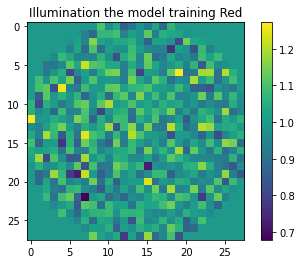

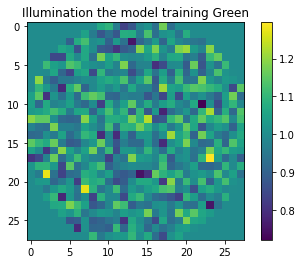

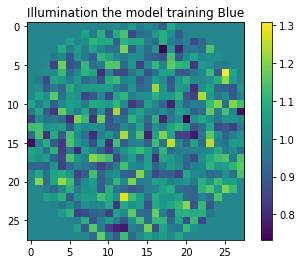

In [104]:
illumination_mask = model.layers[0].get_illumination_phase()
illumination_mask.shape
for i in range(3):
  plt.imshow(np.abs(illumination_mask[0,i,:,:]))
  colors = ["Red", "Green", "Blue"]
  plt.title("Illumination the model training {}".format(colors[i]))
  plt.colorbar()
  plt.show()

Training the model only optimizing the illumination pattern

In [92]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224, 3))
model_il = tf.keras.Sequential()
model_il.add(FullPhysicalLayer28Led(train_aperture=False))
model_il.add(base_model)
model_il.add(tf.keras.layers.Flatten())
model_il.add(tf.keras.layers.Dense(2, activation="sigmoid"))
base_model.trainable = True
model_il.compile(
    metrics=['accuracy'],
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
IMAGE_RES = 224

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [93]:
# because training is slow...
EPOCHS = 35
history = model_il.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/35
603/603 [==============================] - 101s 167ms/step - loss: 0.5070 - accuracy: 0.7940 - val_loss: 0.8168 - val_accuracy: 0.4965
Epoch 2/35
603/603 [==============================] - 100s 166ms/step - loss: 0.4390 - accuracy: 0.8711 - val_loss: 0.8168 - val_accuracy: 0.4965
Epoch 3/35
603/603 [==============================] - 100s 166ms/step - loss: 0.4358 - accuracy: 0.8760 - val_loss: 0.8168 - val_accuracy: 0.4965
Epoch 4/35
603/603 [==============================] - 100s 165ms/step - loss: 0.4286 - accuracy: 0.8826 - val_loss: 0.8020 - val_accuracy: 0.5088
Epoch 5/35
603/603 [==============================] - 100s 166ms/step - loss: 0.4302 - accuracy: 0.8801 - val_loss: 0.7198 - val_accuracy: 0.5517
Epoch 6/35
603/603 [==============================] - 100s 166ms/step - loss: 0.4156 - accuracy: 0.8957 - val_loss: 0.7658 - val_accuracy: 0.5391
Epoch 7/35
603/603 [==============================] - 100s 166ms/step - loss: 0.4112 - accuracy: 0.9000 - val_loss: 0.6731 -

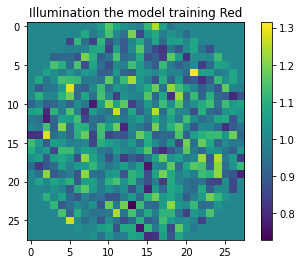

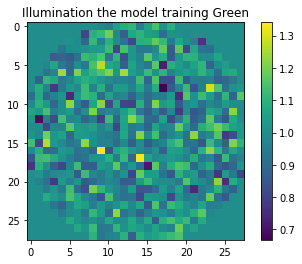

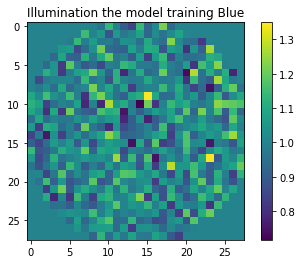

In [97]:
illumination_mask = model_il.layers[0].get_illumination_phase()
illumination_mask.shape
for i in range(3):
  plt.imshow(np.abs(illumination_mask[0,i,:,:]))
  colors = ["Red", "Green", "Blue"]
  plt.title("Illumination the model training {}".format(colors[i]))
  plt.colorbar()
  plt.show()

0.9421943219680897


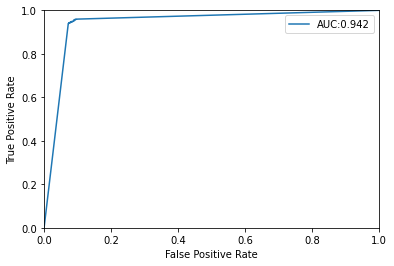

In [32]:
from sklearn.metrics import roc_curve,roc_auc_score
test=model.predict_proba(validation_batches)
res = list(validation_batches)
y_exp = []
for im, lbl in res:
  y_exp.append(lbl.numpy().tolist())
  #print(lbl.numpy().tolist())
len(y_exp)
List_flat = list(itertools.chain(*y_exp))

fpr , tpr , thresholds = roc_curve ( np.array(List_flat) , test[:,1])
auc_score=roc_auc_score(np.array(List_flat) , test[:,1]) 
print(auc_score)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend(["AUC:{:.3f}".format(auc_score)])
  plt.show()    
  
plot_roc_curve (fpr,tpr) 

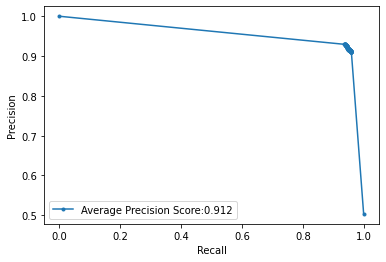

In [36]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
precision, recall, _ = precision_recall_curve(np.array(List_flat) , test[:,1])
avg_precision = average_precision_score(np.array(List_flat) , test[:,1])
plt.plot(recall, precision, marker='.',label="Average Precision Score:{:.3f}".format(avg_precision))
	# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
	# show the legend
plt.legend()
	# show the plot
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


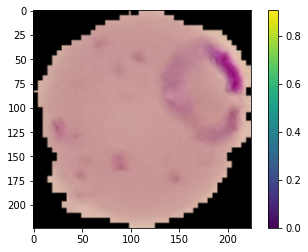

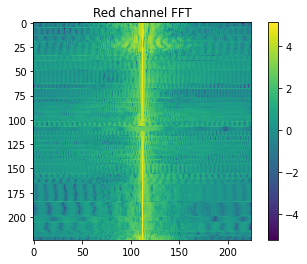

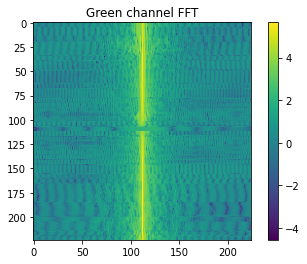

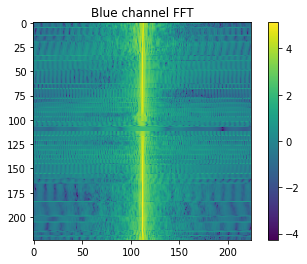

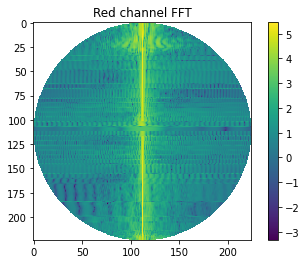

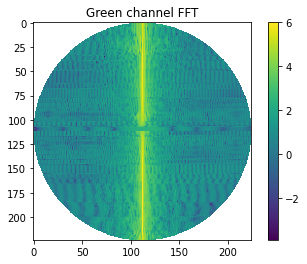

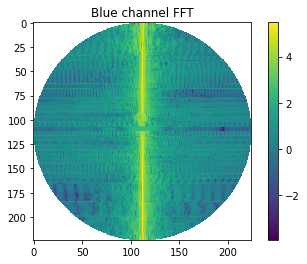

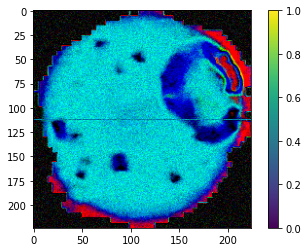

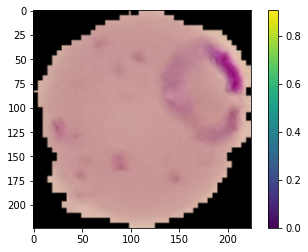

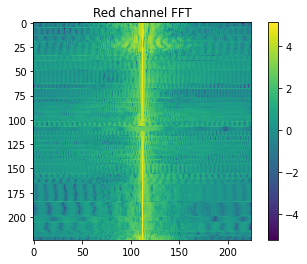

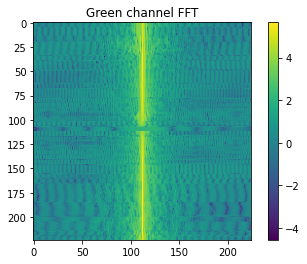

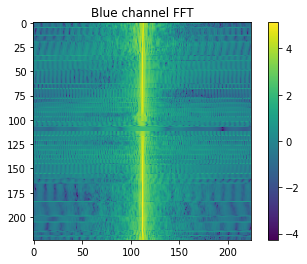

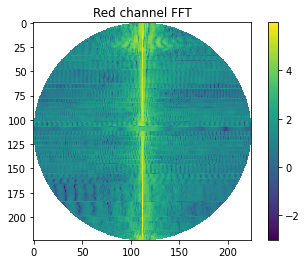

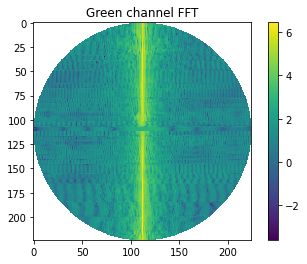

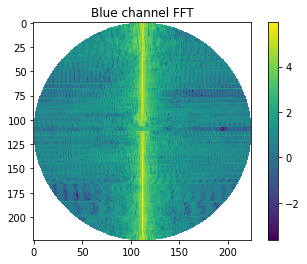

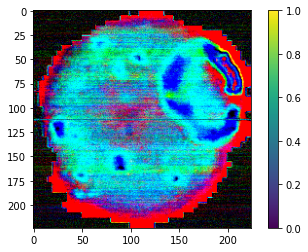

In [105]:
selected_batch = None
selected_labels = None
for image, label in train_batches.take(1):
  selected_batch = image
  selected_labels = label
input_illumination_phase = tf.Variable(initial_value=tf.ones([3,224, 224], dtype="float32"), constraint=lambda t: tf.clip_by_value(t, 0, 2*np.pi), trainable=True)
i_input_illumination_phase = tf.Variable(initial_value=tf.zeros([3,224, 224], dtype="float32"), constraint=lambda t: tf.clip_by_value(t, 0, 2*np.pi), trainable=True)
    
aperture_phase = tf.Variable(initial_value=tf.ones([3,224, 224], dtype="float32"), trainable=False)
i_aperture_phase = tf.Variable(initial_value=tf.ones([3,224, 224], dtype="float32"), trainable=False)

aperture =   tf.complex(aperture_phase, i_aperture_phase)
illumination =   tf.complex(input_illumination_phase, i_input_illumination_phase)
plot_physical_layer(selected_batch, aperture, illumination)
plot_physical_layer_28LED(selected_batch, model.layers[0].input_illumination_phase,model.layers[0].i_input_illumination_phase, model.layers[0].get_aperture_phase())

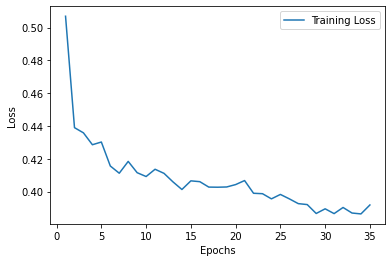

In [106]:
loss_values = history.history['loss'] 
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

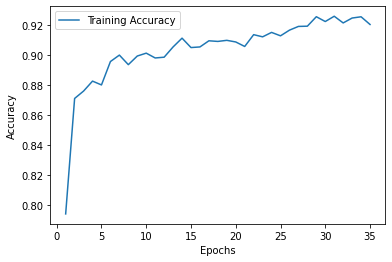

In [107]:
loss_values = history.history['accuracy'] 
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

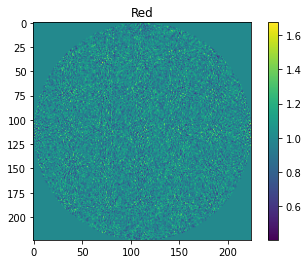

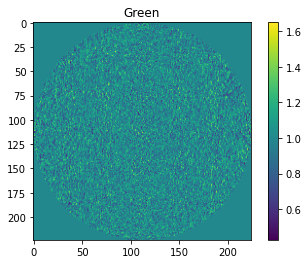

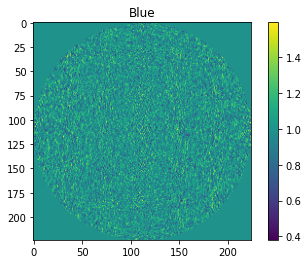

In [41]:
illumination_mask = model.layers[0].get_illumination_phase()
illumination_mask.shape
for i in range(3):
  plt.imshow(np.abs(illumination_mask[i,:,:]))
  colors = ["Red", "Green", "Blue"]
  plt.title("{}".format(colors[i]))
  plt.colorbar()
  plt.show()

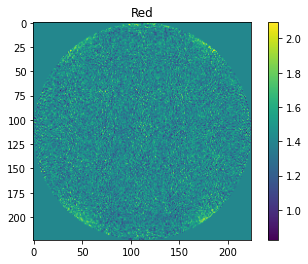

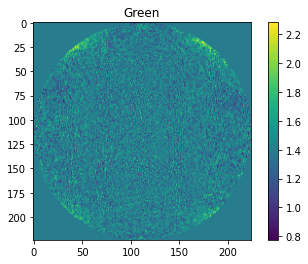

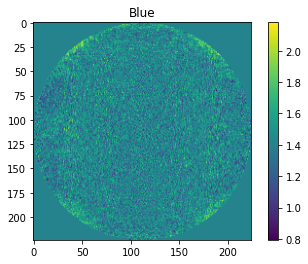

In [39]:
aperture_mask = model.layers[0].get_aperture_phase()
aperture_mask.shape
for i in range(3):
  plt.imshow(np.abs(aperture_mask[i,:,:]))
  colors = ["Red", "Green", "Blue"]
  plt.title("{}".format(colors[i]))
  plt.colorbar()
  plt.show()

In [108]:
res = list(test_batches)
y_exp = []
for im, lbl in res:
  y_exp.append(lbl.numpy().tolist())
  #print(lbl.numpy().tolist())
len(y_exp)
List_flat = list(itertools.chain(*y_exp))

In [110]:
y_pred = model.predict_classes(test_batches)
con_mat = tf.math.confusion_matrix(labels=List_flat, predictions=y_pred).numpy()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [111]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
import pandas as pd
import seaborn as sns
classes=[0,1]
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

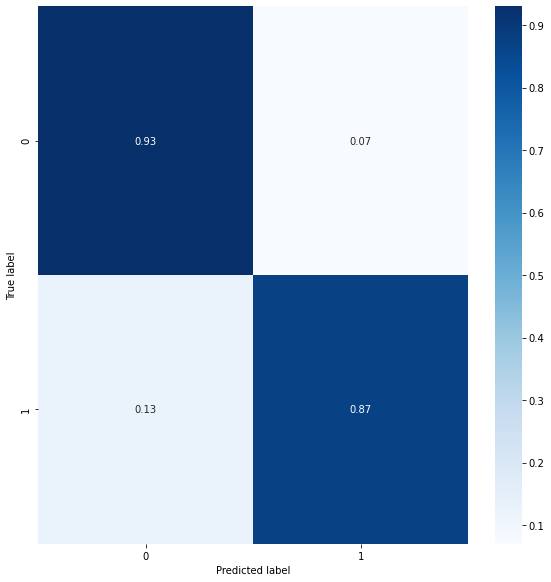

In [112]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

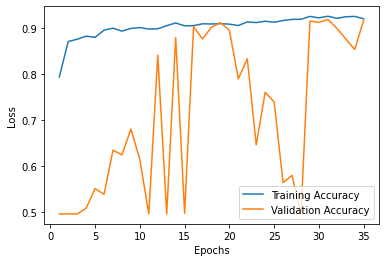

In [113]:
loss_values = history.history['accuracy']
val_loss_values = history.history['val_accuracy'] 
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, label='Training Accuracy')
plt.plot(epochs, val_loss_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
import pandas as pd
import seaborn as sns
classes=[0,1]
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

In [ ]:

res = list(validation_batches)
y_exp = []
for im, lbl in res:
  y_exp.append(lbl.numpy().tolist())
  print(lbl.numpy().tolist())
len(y_exp)
List_flat = list(itertools.chain(*y_exp))

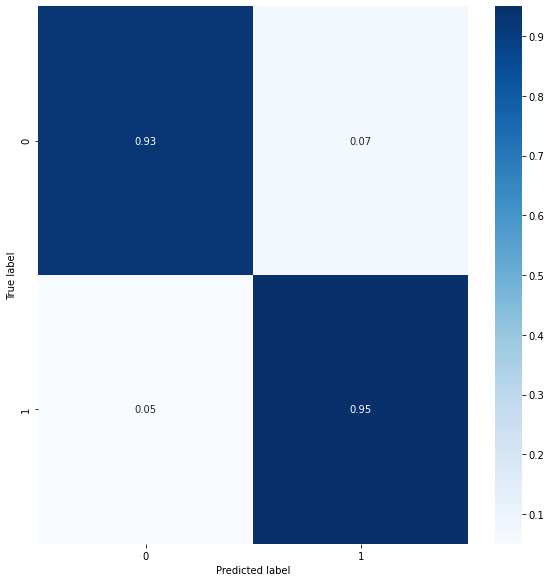

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()